# Feature Engineering and Model Building to Predict Car Dwell Times at Rumford Station
---

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import time
plt.style.use('fivethirtyeight')
%matplotlib notebook

In [2]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%matplotlib notebook

# Feature Engineering

### Import the DataFrame generated in earlier exploratory data analysis

In [4]:
path = r'C:\Users\Lenovo Thinkpad W520\Documents\Data Science\Projects\Final Project\Datasets\df_trains.hdf5'
df_trains = pd.read_hdf(key='df_trains',path_or_buf=path)
df_trains.head()

,Equipment ID,LE Status,AAR Car Type,AAR Car Kind,AAR Car Type Description,System Car,Length,Feet,Inches,Bad Order Ind,...,Constructive Placement Ind,Received Date,Received Time,Hours at Station,Dwell Hours,Storage Ind,Car Hire Rate,Create Date,Create Time,Max Dwell Hours
3,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-07-03,1050.0,96,11.300000,,0.64,2018-08-20,608,6.650000
4,CAR1 0594,L,B357,B,Box Cars,N,5507,55,7,,...,N,2018-07-03,1050.0,0,0.916667,,0.64,2018-08-21,616,6.650000
29,CAR1 1387,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-06,1020.0,249,-14.916667,,0.64,2018-07-25,605,8.183333
65,CAR1 1876,E,B357,B,Box Cars,N,5507,55,7,,...,N,2018-09-12,820.0,17,17.733333,,0.64,2018-09-16,659,40.950000
81,CAR1 1943,E,B357,B,Box Cars,N,5507,55,7,,...,Y,2018-07-03,1050.0,13,5.733333,,0.64,2018-07-12,614,56.583333


### Clean up numerical features
---
- Condense `Length`, `Feet` and `Inches` into one column of type float representing the length of the cat in feet.

In [5]:
# Calculate car length in feet:
df_trains['Length_in_ft'] = df_trains['Feet']+df_trains['Inches']/12

# Drop the old columns
df_trains.drop('Length', axis='columns', inplace=True)
df_trains.drop('Feet', axis='columns', inplace=True)
df_trains.drop('Inches', axis='columns', inplace=True)

In [6]:
# Drop the STCC codes for cargo because it is a categorical number that is better represented by STCC Description
df_trains.drop('STCC', axis='columns', inplace=True)

In [7]:
# Transform the 'Last Move Date' and 'Last Move Time' to 'hours_since_last_move'

mins=[]
hours=[]
for time in df_trains['Last Move Time'].astype(str):
    hours.append(time[:-2])
    mins.append(time[2:5])

c_mins=[]
c_hours=[]    
for time in df_trains['Create Time'].astype(str):
    c_hours.append(time[:-2])
    c_mins.append(time[2:5])

df_rec_times = pd.DataFrame({'year':  pd.DatetimeIndex(df_trains['Last Move Date']).year,
                             'month': pd.DatetimeIndex(df_trains['Last Move Date']).month,
                             'day': pd.DatetimeIndex(df_trains['Last Move Date']).day,
                             'hour': hours,
                             'minute': mins},index = df_trains.index)

df_create_times = pd.DataFrame({'year':  pd.DatetimeIndex(df_trains['Create Date']).year,
                             'month': pd.DatetimeIndex(df_trains['Create Date']).month,
                             'day': pd.DatetimeIndex(df_trains['Create Date']).day,
                             'hour': c_hours,
                             'minute': c_mins},index = df_trains.index)

df_trains['last_move_datetime'] = pd.to_datetime(df_rec_times)
df_trains['create_datetime'] = pd.to_datetime(df_create_times)
df_trains['hours_since_last_move'] = (df_trains['create_datetime']-df_trains['last_move_datetime'])

df_trains['hours_since_last_move'] = [x.total_seconds()/3600 for x in df_trains['hours_since_last_move']]

In [8]:
# Drop the extra columns
df_trains.drop('last_move_datetime', axis='columns', inplace=True)
df_trains.drop('Last Move Date', axis='columns', inplace=True)
df_trains.drop('Last Move Time', axis='columns', inplace=True)

In [9]:
df_trains.isnull().sum()

Equipment ID                    0
LE Status                       0
AAR Car Type                    0
AAR Car Kind                    0
AAR Car Type Description        0
System Car                      0
Bad Order Ind                   0
Track ID                        0
STCC Description                0
Weight                          0
Tare Weight                     0
Last Move Type                  0
Shipper Customer ID             0
Block To Customer ID            0
Block To Address Type           0
Switch To                       0
Switch To Address Type          0
Switch To Customer ID           0
Traffic Type                    0
Placement Ind                   0
Constructive Placement Ind      0
Received Date                 347
Received Time                 347
Hours at Station                0
Dwell Hours                     0
Storage Ind                     0
Car Hire Rate                   0
Create Date                     0
Create Time                     0
Max Dwell Hour

<IPython.core.display.Javascript object>


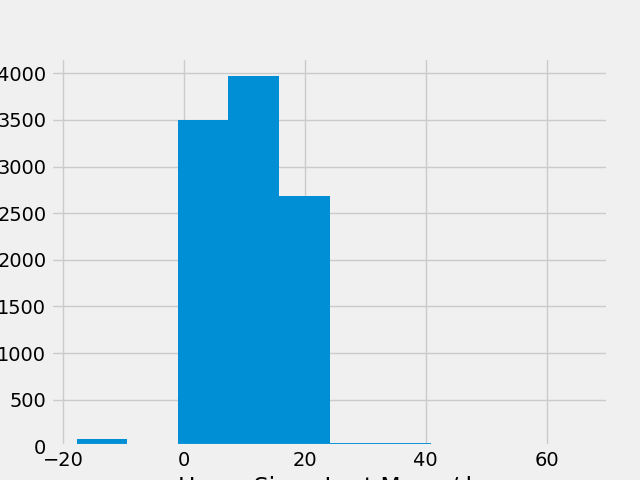

Text(0.5,0,'Hours Since Last Move / h')

In [10]:
fig,ax = plt.subplots()

df_trains.hours_since_last_move.plot(kind='hist',ax=ax)
ax.set_xlabel('Hours Since Last Move / h')

In [11]:
# Fill in missing values for 'housr_since_last_move'
mean_hours = df_trains['hours_since_last_move'].mean()

filled=[]
for val in df_trains['hours_since_last_move']:
    if str(val)=='nan':
        filled.append(mean_hours)
    else:
        filled.append(val)

df_trains['hours_since_last_move'] = filled
df_trains['hours_since_last_move'].isnull().sum()

0

### Get non-numerical feature dummies
---
- `Create Date` is transformed into a season column. This data set is not reated as a time series.  
- `Received Time` is transformed into `came_normal_working_hours` column
- `Received Date` is dropped because it is colinear with `Create Date` and contains missing values
- `Dwell Hours` is dropped because it is inconsequential at the time of arrival
- `AAR Car Kind` and `AAR Car Type Description` are dropped because they are implied by the more informative `AAR Car Type`


<IPython.core.display.Javascript object>


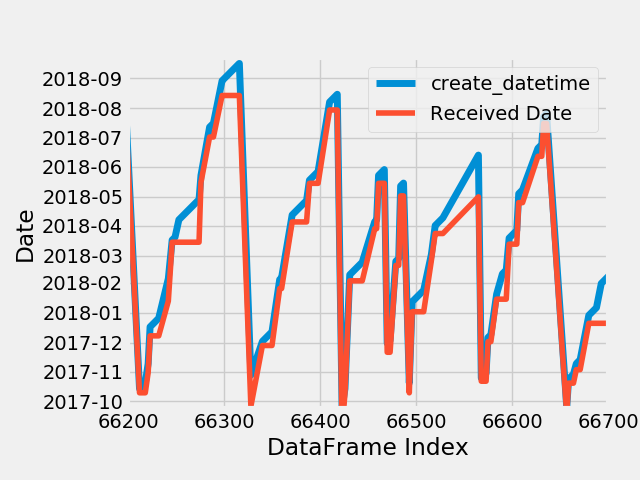

In [12]:
# Show 'Create Date' and 'Received Date' are colinear
fig,ax= plt.subplots()

plt.gcf().subplots_adjust(left=0.20) 
plt.gcf().subplots_adjust(bottom=0.15)

ax.plot(df_trains['create_datetime'],linewidth=5)
ax.plot(df_trains['Received Date'])

ax.set_xlabel('DataFrame Index')
ax.set_ylabel('Date')
ax.set_xlim(66200,66700)
ax.set_ylim(df_trains['create_datetime'].min(), df_trains['create_datetime'].max())

leg=ax.legend()

In [13]:
#Transform 'Create Date' into season column
spring_day = pd.to_datetime('2018-03-20',yearfirst=True)
summer_day = pd.to_datetime('2018-03-20',yearfirst=True)
fall_day = pd.to_datetime('2018-06-21',yearfirst=True)
winter_day = pd.to_datetime('2017-12-21',yearfirst=True)

df_trains['is_winter']  = (df_trains['create_datetime']>=winter_day) & (df_trains['Create Date']<spring_day)
df_trains['is_spring']  = (df_trains['create_datetime']>=spring_day) & (df_trains['Create Date']<summer_day)
df_trains['is_summer']  = (df_trains['create_datetime']>=summer_day) & (df_trains['Create Date']<fall_day)
df_trains['is_fall']  = (df_trains['is_winter']==False) & (df_trains['is_spring']==False) & df_trains['is_summer']==False

df_trains['is_spring'] = df_trains['is_spring'].map({True: 1, False:0})
df_trains['is_summer'] = df_trains['is_summer'].map({True: 1, False:0})
df_trains['is_fall'] = df_trains['is_fall'].map({True: 1, False:0})
df_trains.drop('is_winter', axis='columns', inplace=True)

In [14]:
# Drop 'Create Date' and 'Create Time'
df_trains.drop('Create Date', axis='columns', inplace=True)
df_trains.drop('Create Time', axis='columns', inplace=True)
df_trains.drop('create_datetime', axis='columns', inplace=True)

In [15]:
# Transform Received Time to "came_normal_working_hours"
start_time = 9
end_time = 17
df_trains['came_normal_working_hours']  = (df_trains['Received Time']>=start_time) & (df_trains['Received Time']<end_time)

# Drop the old 'Received Time' column
df_trains.drop('Received Time', axis='columns', inplace=True)

In [16]:
# Drop 'Received Date' because it has more missing values
df_trains.drop('Received Date', axis='columns', inplace=True)

In [17]:
# Drop 'AAR Car Kind' and 'AAR Car Type Description' because it is implied by "AAR Car Type"
df_trains.drop('AAR Car Kind', axis='columns', inplace=True)
df_trains.drop('AAR Car Type Description', axis='columns', inplace=True)

In [18]:
# Drop cumulative arrival "Dwell Hours" because it is inconsequential
df_trains.drop('Dwell Hours', axis='columns', inplace=True)

In [19]:
# Drop 'Switch To' because it is redundant with the independent features 'Switch To Address Type' and 'Switch To Customer ID'
df_trains.drop('Switch To', axis='columns', inplace=True)

In [20]:
# Drop the columns used to filter the full snapshots dataset to get df_trains because they are all the same values
df_trains.drop('Bad Order Ind', axis='columns', inplace=True)
df_trains.drop('Placement Ind', axis='columns', inplace=True)
df_trains.drop('Storage Ind', axis='columns', inplace=True)

In [21]:
df_trains['Log Max Dwell Hours'] = np.log10(df_trains['Max Dwell Hours'])

### DataFrame with dummies
---
Total number of features: ~2700   
Target Value: Log$_1$$_0$ of the maximum dwell time of each arriving car

In [22]:
target_col = 'Log Max Dwell Hours'
df_trains.drop('Max Dwell Hours',axis='columns', inplace=True)

In [23]:
# target_col = 'Max Dwell Hours'
# df_trains.drop('Log Max Dwell Hours',axis='columns', inplace=True)

In [24]:
#Make dummy columms of the rest of the non-numerical features
dummy_cols = df_trains.columns[df_trains.dtypes==object]
df_trains = pd.get_dummies(df_trains, columns=dummy_cols,drop_first=True)
df_trains.shape

(11049, 2701)

In [25]:
df_trains.head()

,Weight,Tare Weight,Hours at Station,Car Hire Rate,Length_in_ft,hours_since_last_move,is_spring,is_summer,is_fall,came_normal_working_hours,...,Switch To Customer ID_SPRMER,Switch To Customer ID_STENGR,Switch To Customer ID_STMECH,Switch To Customer ID_TIGWAR,Switch To Customer ID_VTR,Switch To Customer ID_WATV,Traffic Type_F,Traffic Type_L,Traffic Type_R,Constructive Placement Ind_Y
3,138173,65600,96,0.64,55.583333,11.300000,0,0,1,False,...,0,0,0,0,0,0,1,0,0,0
4,138173,65600,0,0.64,55.583333,1.083333,0,0,1,False,...,0,0,0,0,0,0,0,1,0,0
29,0,67200,249,0.64,55.583333,-14.916667,0,0,1,False,...,0,0,0,0,0,0,0,1,0,1
65,0,66300,17,0.64,55.583333,16.900000,0,0,1,False,...,0,0,0,0,0,0,0,0,1,0
81,0,66700,13,0.64,55.583333,10.499576,0,0,1,False,...,0,0,0,0,0,0,0,1,0,1


<IPython.core.display.Javascript object>


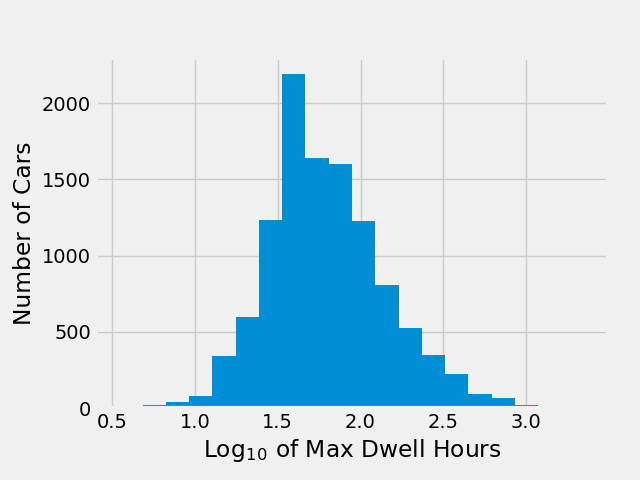

In [26]:
# Plot the the target values. They are basically log normal.
fig,ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

ax.set_xlabel('Log$_1$$_0$ of Max Dwell Hours')
ax.set_ylabel('Number of Cars')

ax.hist(df_trains[target_col],bins=20);

# Model Building
---
Below, linear regression, decision tree, bagged decision trees and random forest models are created. Generally, all overfit the training data and when attempts at variance reduction are made via reduciton of the number of features, the resulting increase in bias mase for a worse overall fit to the data.

In [27]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures

### Do the splits

In [28]:
feature_cols = df_trains.columns.drop(target_col)
X = df_trains[feature_cols]
y = df_trains[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=1)

In [29]:
kf = KFold(n_splits=5, shuffle=True)

### Make the null model to beat
---
The null model predicts the average dwell time everytime   
Null model training MSE: **0.212**   
Null model test MSE: **0.127**

In [30]:
y_null_pred_train = np.zeros(len(y_train))+np.mean(y_train)
null_train_MSE = metrics.mean_squared_error(y_pred=y_null_pred_train,y_true=y_train)

y_null_pred = np.zeros(len(y_test))+np.mean(y_train)
null_test_MSE = metrics.mean_squared_error(y_pred=y_null_pred,y_true=y_test)

print('Null Train MSE: '+str(null_train_MSE))
print('Null Test MSE: '+str(null_test_MSE))

Null Train MSE: 0.12161271942471846
Null Test MSE: 0.12680489540167067


### Linear regression model
---
- This model fits the training set slightly better, but fits the test much worse. This is indicative of a variance problem.
- Attemps to reduce the variance of the model with fewer features result in a better overall fit, but is still not very accurate.
---
LR model training MSE: **0.068**   
LR model test MSE: **4.39e+12**   
Cross validation MSE = **1.48E+10**

In [132]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
lr_pred_train = lr.predict(X_train)

lr_train_MSE = metrics.mean_squared_error(y_pred=lr_pred_train,y_true=y_train)
lr_test_MSE = metrics.mean_squared_error(y_pred=lr_pred,y_true=y_test)
lr_MSE = np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error'))

print('LR Train MSE: '+str(lr_train_MSE))
print('LR Test MSE: '+str(lr_test_MSE))
print('LR MSE: '+str(lr_MSE))

LR Train MSE: 0.06844154987473419
LR Test MSE: 4394334267622.155
LR MSE: 34707182933.36383


---
#### Reduce flexibility of linear regression model by removing features
This does eliminates overfitting, but the model is still a poor fit and remains very biased.   
   
LR model training MSE: **0.103**   
LR model test MSE: **0.106**    
Cross validation MSE = **0.104**

---

In [32]:
# By correlation matrix
lr_corr_coefs = df_trains.corrwith(df_trains[target_col]).drop(target_col,axis='rows').apply('abs').sort_values(ascending=False)
lr_corr_coefs

Traffic Type_R                      0.281043
Switch To Address Type_RUM          0.277783
Block To Address Type_RUM           0.277592
STCC Description_LIMESTONE SLURY    0.255056
Shipper Customer ID_OMYA            0.255056
Switch To Customer ID_CATPAP        0.250200
Block To Customer ID_CATPAP         0.249988
Constructive Placement Ind_Y        0.239161
Traffic Type_F                      0.223049
Last Move Type_LOC                  0.210286
Shipper Customer ID_CATPAP          0.195104
hours_since_last_move               0.161659
Weight                              0.159105
Track ID_04                         0.158255
Length_in_ft                        0.148849
Track ID_07                         0.144424
Switch To Address Type_YD           0.142843
AAR Car Type_T104                   0.140902
Last Move Type_RLOD                 0.127746
STCC Description_PAPER PRINTING     0.125344
Car Hire Rate                       0.122050
LE Status_L                         0.119707
Switch To 

In [72]:
feature_cols_reduced = lr_corr_coefs.index[lr_corr_coefs>0.09]#.drop(target_col)
print(len(feature_cols_reduced))
feature_cols_reduced

36


Index(['Traffic Type_R', 'Switch To Address Type_RUM',
       'Block To Address Type_RUM', 'STCC Description_LIMESTONE SLURY',
       'Shipper Customer ID_OMYA     ', 'Switch To Customer ID_CATPAP   ',
       'Block To Customer ID_CATPAP   ', 'Constructive Placement Ind_Y',
       'Traffic Type_F', 'Last Move Type_LOC ',
       'Shipper Customer ID_CATPAP   ', 'hours_since_last_move', 'Weight',
       'Track ID_04        ', 'Length_in_ft', 'Track ID_07        ',
       'Switch To Address Type_YD ', 'AAR Car Type_T104',
       'Last Move Type_RLOD', 'STCC Description_PAPER PRINTING ',
       'Car Hire Rate', 'LE Status_L ', 'Switch To Address Type_DAN',
       'Block To Address Type_DAN', 'LE Status_E ',
       'Switch To Customer ID_SLR      ', 'Block To Customer ID_CSXT     ',
       'Block To Address Type_BRB', 'Switch To Address Type_BRB',
       'Switch To Customer ID_CSXT     ', 'STCC Description_**EMPTY**      ',
       'Track ID_OLD MAIN  ', 'AAR Car Type_A402', 'Track ID_01    

In [73]:
X2 = df_trains[feature_cols_reduced]
y2 = df_trains[target_col]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, shuffle=True, random_state=1)

In [39]:
lr2 = LinearRegression()
lr2.fit(X_train2,y_train2)
lr2_pred = lr2.predict(X_test2)
lr2_pred_train = lr2.predict(X_train2)

lr2_train_MSE = metrics.mean_squared_error(y_pred=lr2_pred_train,y_true=y_train2)
lr2_test_MSE = metrics.mean_squared_error(y_pred=lr2_pred,y_true=y_test2)
lr2_MSE = np.mean(-cross_val_score(lr2, X2, y2, cv=kf, scoring='neg_mean_squared_error'))

print('LR Train MSE: '+str(lr2_train_MSE))
print('LR Test MSE: '+str(lr2_test_MSE))
print('LR CV MSE: '+str(lr2_MSE))

LR Train MSE: 0.10862430834031611
LR Test MSE: 0.11159948555800767
LR CV MSE: 0.10941864205858838


<IPython.core.display.Javascript object>


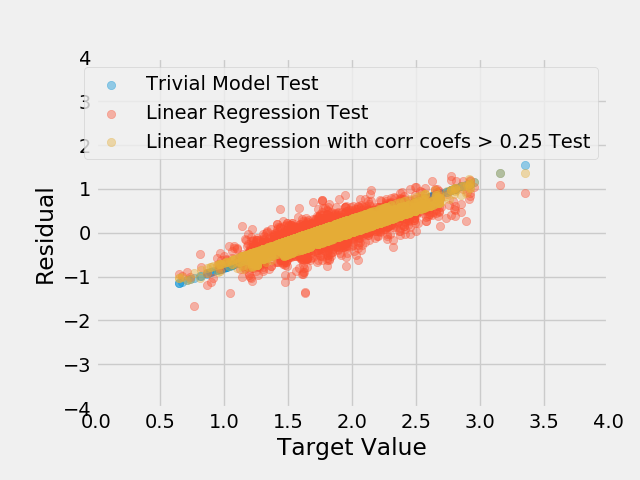

In [41]:
# Plot residuals for each linear regression model: 
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

null_residuals = y_test - y_null_pred
lr_residuals = y_test - lr_pred
lr2_residuals = y_test - lr2_pred

maxi=4
alpha = 0.4

ax.scatter(y_test, null_residuals, label='Trivial Model Test',alpha = alpha)
ax.scatter(y_test, lr_residuals, label='Linear Regression Test',alpha = alpha)
ax.scatter(y_test, lr2_residuals, label='Linear Regression with corr coefs > 0.25 Test',alpha = alpha)

# ax.scatter(y_train, y_train - y_null_pred_train, label='Trivial Model Train',alpha = alpha)
# ax.scatter(y_train, y_train - lr_pred_train, label='Linear Regression Train',alpha = alpha)
# ax.scatter(y_train, y_train - lr2_pred_train, label='Linear Regression coefs > 0.1 Train',alpha = alpha)

ax.set_xlabel('Target Value')
ax.set_ylabel('Residual')
ax.set_xlim(0,maxi)
ax.set_ylim(-maxi,maxi)

leg=ax.legend()

---
#### Higher order polynomial fits on reduced number of features
The flexibility was reduced too much and is now too biased on the fit and training data. This step was done to add back flexibility to reduce the bias of a less featured model from the 2700 feature model by adding squares and cubes of the remaining features. This showed no change in the MSE.

1st Order cross validation MSE: **0.104**   
2nd Order cross validation MSE: **0.112**    
3rd Order cross validation MSE: = **Took to long to run**

---

In [42]:
for poly_degree in range(1, 3):
    pf = PolynomialFeatures(degree=poly_degree, include_bias=False)
    X_poly = pf.fit_transform(X2)
    lr_poly = LinearRegression() 
    score = np.mean(-cross_val_score(lr_poly, X_poly, y2, cv=kf, scoring='neg_mean_squared_error'))
    print(poly_degree, score)#train_score, test_score,score)

1 0.10950609756837922
2 0.10955384289281667


### Decision Tree Model
---
Decision tree model training MSE: **1.85e-09**   
Decision tree model test MSE: **0.127**  
Decision tree model cross validaiton MSE = **0.125**


---
This model fits the training set much better, but is still overfit as it still fits the test set poorly, but the training set perfectly. This is indicative of a remaining variance problem. Attempting to reduce the variance with a less featured model resulted in a worse fit with increased bias.

---
Optimum max_depth was determined to be 10 using all the features (max_depth=None)

In [43]:
# Fit with no max depth
treereg = DecisionTreeRegressor()#max_features = 1100, max_depth = 7, random_state=1)
treereg.fit(X_train,y_train)
treereg_pred = treereg.predict(X_test)
treereg_pred_train = treereg.predict(X_train)

treereg_train_MSE = metrics.mean_squared_error(y_pred=treereg_pred_train,y_true=y_train)
treereg_test_MSE = metrics.mean_squared_error(y_pred=treereg_pred,y_true=y_test)
treereg_MSE = np.mean(-cross_val_score(treereg, X, y, cv=kf, scoring='neg_mean_squared_error'))

print('Treereg Train MSE: '+str(treereg_train_MSE))
print('Treereg Test MSE: '+str(treereg_test_MSE))
print('Treereg CV MSE: '+str(treereg_MSE))

Treereg Train MSE: 1.8285126358826408e-09
Treereg Test MSE: 0.12769392962415677
Treereg CV MSE: 0.13032760988133946


<IPython.core.display.Javascript object>


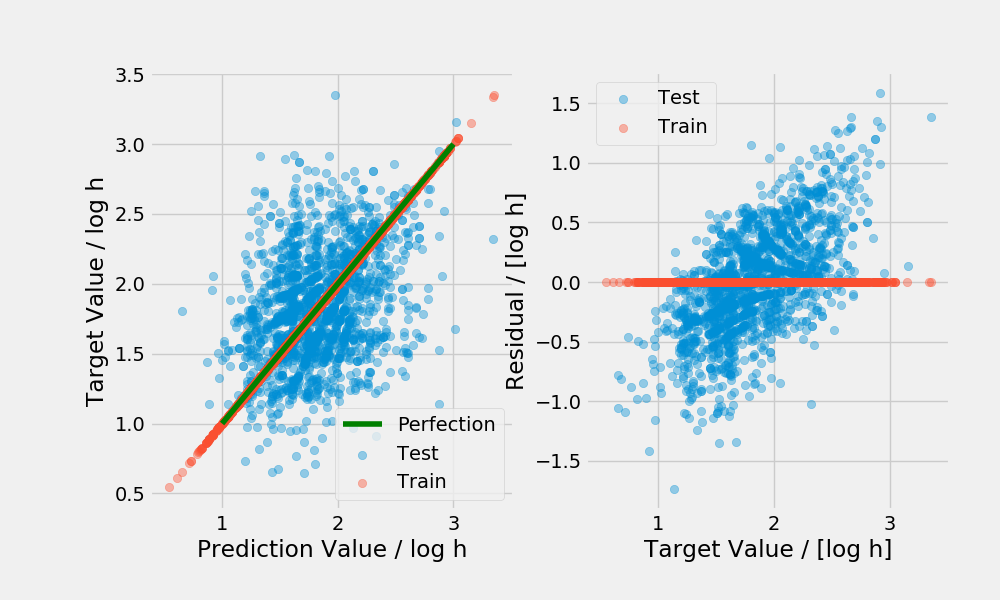

In [44]:
# "Goodness" plots for the overfit decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(treereg_pred, y_test, label='Test', alpha=alpha)
axes[0].scatter(treereg_pred_train, y_train, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test, y_test-treereg_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train, y_train-treereg_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


In [80]:
# Fit with reduced number of features 
treereg2 = DecisionTreeRegressor()
treereg2.fit(X_train2,y_train2)
treereg2_pred = treereg2.predict(X_test2)
treereg2_pred_train = treereg2.predict(X_train2)

treereg2_train_MSE = metrics.mean_squared_error(y_pred=treereg2_pred_train,y_true=y_train2)
treereg2_test_MSE = metrics.mean_squared_error(y_pred=treereg2_pred,y_true=y_test2)
treereg2_MSE = np.mean(-cross_val_score(treereg2, X2, y2, cv=kf, scoring='neg_mean_squared_error'))

print('Treereg Train MSE: '+str(treereg2_train_MSE))
print('Treereg Test MSE: '+str(treereg2_test_MSE))
print('Treereg CV MSE: '+str(treereg2_MSE))

Treereg Train MSE: 0.006182256760396304
Treereg Test MSE: 0.1406004538132999
Treereg CV MSE: 0.14075429340282689


<IPython.core.display.Javascript object>


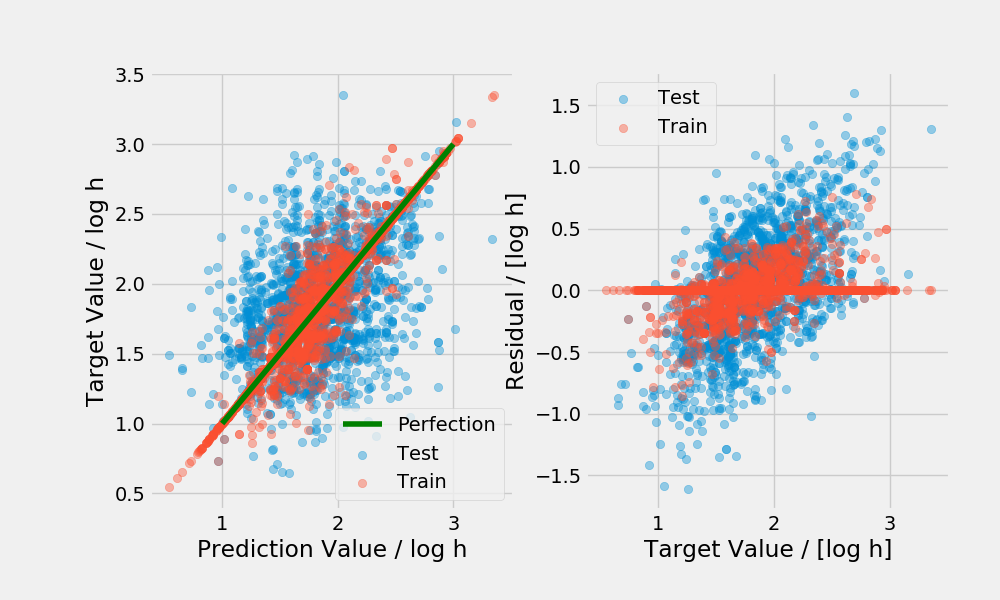

In [81]:
# "Goodness" plots for the overfit decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(treereg2_pred, y_test2, label='Test', alpha=alpha)
axes[0].scatter(treereg2_pred_train, y_train2, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test2, y_test-treereg2_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train2, y_train-treereg2_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


In [41]:
# fit for a range of max features and plot the MSEs for each
train_MSE_scores = []
test_MSE_scores = []
CV_MSE_scores = []
max_depth_range = range(1,20)

for max_depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=max_depth, max_features=len(X_train.columns), random_state=1)
    treereg.fit(X_train,y_train)
    
    treereg_pred_train = treereg.predict(X_train)
    treereg_pred = treereg.predict(X_test)
    
    treereg_train_MSE = metrics.mean_squared_error(y_pred=treereg_pred_train,y_true=y_train)
    treereg_test_MSE = metrics.mean_squared_error(y_pred=treereg_pred,y_true=y_test)
    treereg_MSE = np.mean(-cross_val_score(treereg, X, y, cv=kf, scoring='neg_mean_squared_error'))
    
    train_MSE_scores.append(np.mean(treereg_train_MSE))
    test_MSE_scores.append(np.mean(treereg_test_MSE))
    CV_MSE_scores.append(treereg_MSE)
    
    print(max_depth)
    print(treereg_train_MSE)
    print(treereg_test_MSE)
    print(treereg_MSE)    

treereg_max_depth_df = pd.DataFrame({'max_depth':max_depth_range,'train':train_MSE_scores,'test':test_MSE_scores,'CV':CV_MSE_scores})
treereg_max_depth_df

1
0.11218811959036573
0.11626138655357962
0.11377320579074816
2
0.10794058025788106
0.1111634559098029
0.1089101247395015
3
0.10429758283931433
0.10831893207613298
0.10674328046134865
4
0.10072552132093485
0.10707985456473844
0.10470361997686548
5
0.09638356550628031
0.10584710498353665
0.10175623562160703
6
0.0922250312534214
0.10499685226711626
0.10078510551146039
7
0.08793784836365323
0.10351735043468584
0.09636895318808551
8
0.08277604971948399
0.1031207951670577
0.09728098938915945
9
0.07810745662900023
0.10101542407433316
0.0981833795525606
10
0.0732573978947466
0.10000295197453563
0.09700046329676493
11
0.06842652348241544
0.10023869527447733
0.09657367905980517
12
0.06363424991833576
0.10080165642360762
0.0981742078701309
13
0.059150869977821166
0.10001140616867063
0.09683524062396284
14
0.05489367480608213
0.10269999080017324
0.09886655003896892
15
0.05056814622926337
0.10235900639885682
0.09841494965664419
16
0.045948889983110225
0.10382117764998439
0.10054426767306439
17
0.0

,max_depth,train,test,CV
0,1,0.112188,0.116261,0.113773
1,2,0.107941,0.111163,0.108910
2,3,0.104298,0.108319,0.106743
3,4,0.100726,0.107080,0.104704
4,5,0.096384,0.105847,0.101756
5,6,0.092225,0.104997,0.100785
6,7,0.087938,0.103517,0.096369
7,8,0.082776,0.103121,0.097281
8,9,0.078107,0.101015,0.098183
9,10,0.073257,0.100003,0.097000


<IPython.core.display.Javascript object>


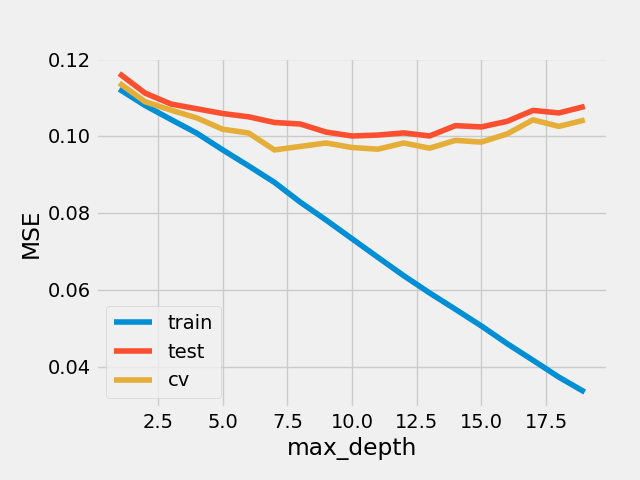

In [77]:
# plot the MSEs of models using the range of max_depths
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

ax.plot(treereg_max_depth_df['max_depth'], treereg_max_depth_df['train'], label='train')
ax.plot(treereg_max_depth_df['max_depth'], treereg_max_depth_df['test'], label='test');
ax.plot(treereg_max_depth_df['max_depth'], treereg_max_depth_df['CV'], label='cv');

ax.set_xlabel('max_depth')
ax.set_ylabel('MSE')
ax.legend();

In [43]:
# fit for a range of max features and plot the MSEs for each
train_MSE_scores = []
test_MSE_scores = []
CV_MSE_scores = []
max_feature_range = range(1,len(X_train.columns)+1,100)

for max_feature in max_feature_range:
    treereg = DecisionTreeRegressor(max_depth=10, max_features=max_feature, random_state=1)
    treereg.fit(X_train,y_train)
    
    treereg_pred_train = treereg.predict(X_train)
    treereg_pred = treereg.predict(X_test)
    
    treereg_train_MSE = metrics.mean_squared_error(y_pred=treereg_pred_train,y_true=y_train)
    treereg_test_MSE = metrics.mean_squared_error(y_pred=treereg_pred,y_true=y_test)
    treereg_MSE = np.mean(-cross_val_score(treereg, X, y, cv=kf, scoring='neg_mean_squared_error'))
    
    train_MSE_scores.append(np.mean(treereg_train_MSE))
    test_MSE_scores.append(np.mean(treereg_test_MSE))
    CV_MSE_scores.append(treereg_MSE)
    
    print(max_feature)
    print(treereg_train_MSE)
    print(treereg_test_MSE)
    print(treereg_MSE)    

treereg_max_feature_df = pd.DataFrame({'max_feaures':max_feature_range,'train':train_MSE_scores,'test':test_MSE_scores,'CV':CV_MSE_scores})
treereg_max_feature_df

1
0.12101981454177142
0.12699017596689408
0.12324389698280827
101
0.099329731823008
0.11181574075803766
0.10655596444732322
201
0.08952615441483011
0.10520806526822946
0.10538958016813205
301
0.08958924873788705
0.10571012188985436
0.10267576791938315
401
0.08131036681734101
0.10301024524854903
0.10140987451730521
501
0.08070853266495961
0.0992950926198067
0.10036181689195603
601
0.0840698688615483
0.10423989453017984
0.09925176113699193
701
0.08108082372896319
0.10044473333513508
0.09892194856688272
801
0.07827388538105541
0.09682194475351645
0.09875089690631307
901
0.07984543145790832
0.10178177014754278
0.09722480350019788
1001
0.07617884469242092
0.10075386992333563
0.10168785166936141
1101
0.0745649200790591
0.10038226936082274
0.09764264671547841
1201
0.07527443136325766
0.1010007350777025
0.09600284180228859
1301
0.07421298346924127
0.10170317777864896
0.09662800343583655
1401
0.07711636533329262
0.10114125759925537
0.09451998254053381
1501
0.07327199033629923
0.0980714559738556

,max_feaures,train,test,CV
0,1,0.121020,0.126990,0.123244
1,101,0.099330,0.111816,0.106556
2,201,0.089526,0.105208,0.105390
3,301,0.089589,0.105710,0.102676
4,401,0.081310,0.103010,0.101410
5,501,0.080709,0.099295,0.100362
6,601,0.084070,0.104240,0.099252
7,701,0.081081,0.100445,0.098922
8,801,0.078274,0.096822,0.098751
9,901,0.079845,0.101782,0.097225


<IPython.core.display.Javascript object>


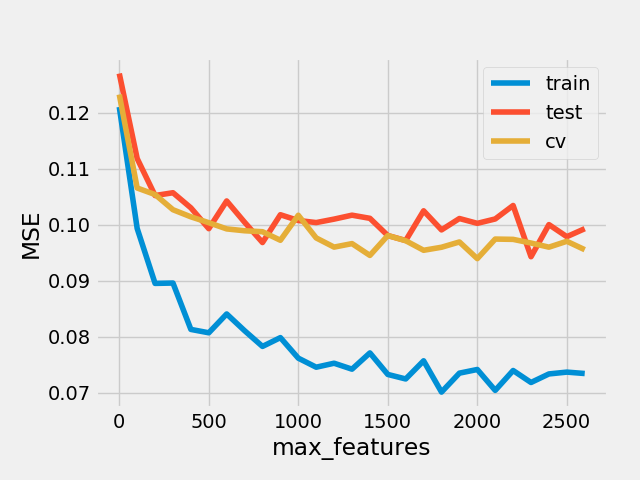

In [78]:
# plot the MSEs of models using the range of max_features
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

ax.plot(treereg_max_feature_df['max_feaures'], treereg_max_feature_df['train'], label='train')
ax.plot(treereg_max_feature_df['max_feaures'], treereg_max_feature_df['test'], label='test')
ax.plot(treereg_max_feature_df['max_feaures'], treereg_max_feature_df['CV'], label='cv')

ax.set_xlabel('max_features')
ax.set_ylabel('MSE')
ax.legend();

In [75]:
# Fit with optimum max depth determined below
treereg = DecisionTreeRegressor(max_features = 2000, random_state=1, max_depth = 12)
treereg.fit(X_train,y_train)
treereg_pred = treereg.predict(X_test)
treereg_pred_train = treereg.predict(X_train)

treereg_train_MSE = metrics.mean_squared_error(y_pred=treereg_pred_train,y_true=y_train)
treereg_test_MSE = metrics.mean_squared_error(y_pred=treereg_pred,y_true=y_test)
treereg_MSE = np.mean(-cross_val_score(treereg, X, y, cv=kf, scoring='neg_mean_squared_error'))

print('Treereg Train MSE: '+str(treereg_train_MSE))
print('Treereg Test MSE: '+str(treereg_test_MSE))
print('Treereg CV MSE: '+str(treereg_MSE))

Treereg Train MSE: 0.06272774276844068
Treereg Test MSE: 0.09519822109478797
Treereg CV MSE: 0.10016001691590884


<IPython.core.display.Javascript object>


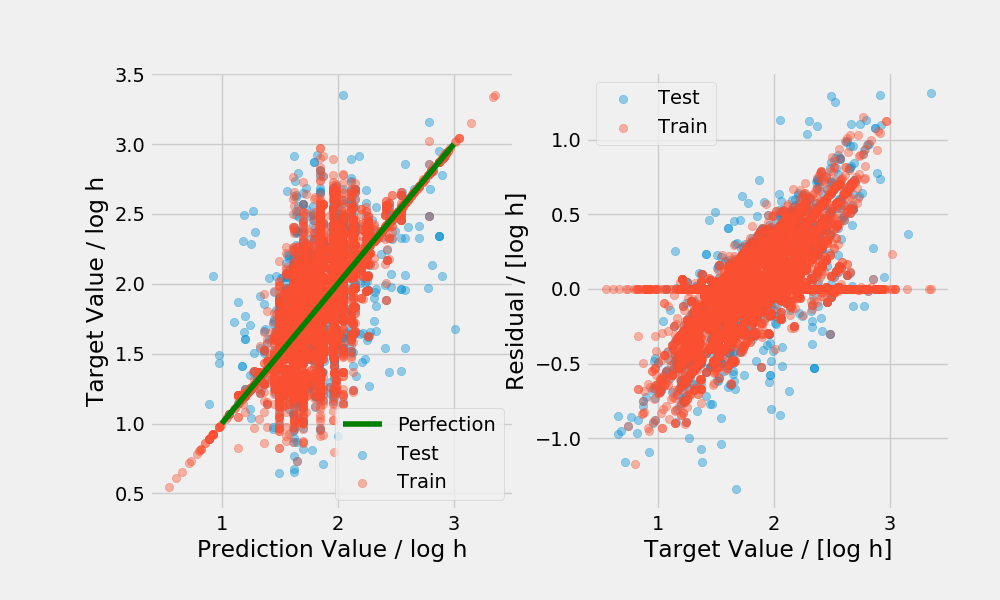

In [76]:
# "Goodness" plots for the reduced variance decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(treereg_pred, y_test, label='Test', alpha=alpha)
axes[0].scatter(treereg_pred_train, y_train, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test, y_test-treereg_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train, y_train-treereg_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


### Bagged Decision Tree
---
- Test MSE improves with bagging, but there is still a strong bias. The model is also still overfit.   
- Increasing n_estimators to values larger than 10 produces diminshing MSE improvements, with no significant improvement with respect to overfitting.
- Error reduces with an incresing number of samples.
---
Bagged decision tree model training MSE: **0.0145**   
Bagged decision tree model test MSE: **0.0852**  
Bagged decision tree model cross validaiton MSE = **0.125**

In [78]:
#Using all the default options

bagreg = BaggingRegressor(DecisionTreeRegressor(random_state=1), random_state=1)
bagreg.fit(X_train, y_train)
bagreg_pred = bagreg.predict(X_test)
bagreg_pred_train = bagreg.predict(X_train)

bagreg_train_MSE = metrics.mean_squared_error(y_pred=bagreg_pred_train,y_true=y_train)
bagreg_test_MSE = metrics.mean_squared_error(y_pred=bagreg_pred,y_true=y_test)
bagreg_MSE = np.mean(-cross_val_score(bagreg, X, y, cv=kf, scoring='neg_mean_squared_error'))


print('Bagged Treereg Train MSE: '+ str(bagreg_train_MSE))
print('Bagged Treereg Test MSE: '+ str(bagreg_test_MSE))
print('Bagged Treereg MSE: '+ str(bagreg_MSE))

Bagged Treereg Train MSE: 0.014528783317437082
Bagged Treereg Test MSE: 0.08524885468424152
Bagged Treereg MSE: 0.08197122839140096


<IPython.core.display.Javascript object>


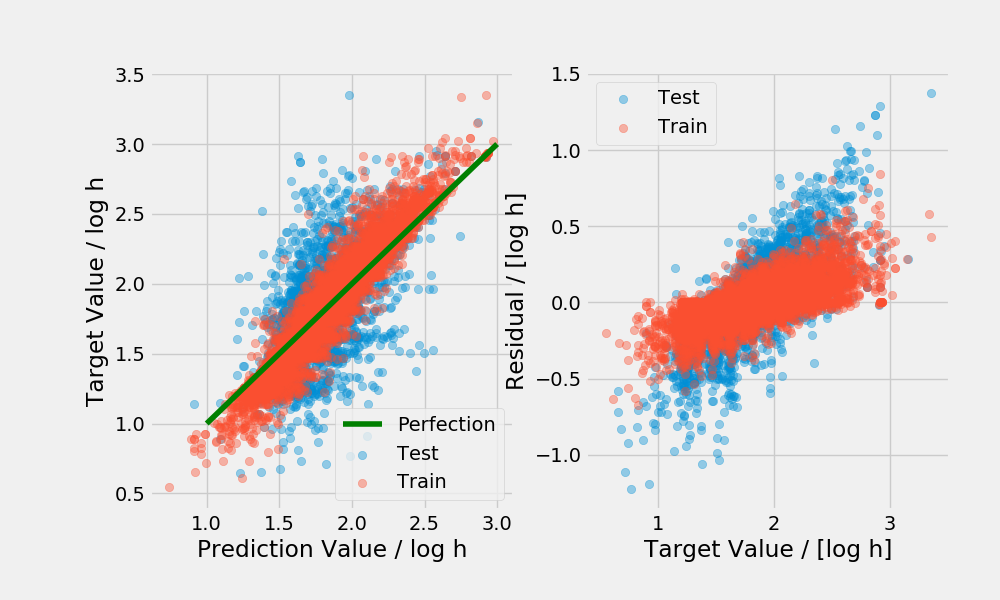

In [79]:
# "Goodness" plots for the reduced variance decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(bagreg_pred, y_test, label='Test', alpha=alpha)
axes[0].scatter(bagreg_pred_train, y_train, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test, y_test-bagreg_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train, y_train-bagreg_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


In [82]:
#Using the reduced number of features to limit overfitting

bagreg2 = BaggingRegressor(DecisionTreeRegressor(random_state=1), random_state=1)
bagreg2.fit(X_train2, y_train2)
bagreg2_pred = bagreg2.predict(X_test2)
bagreg2_pred_train = bagreg2.predict(X_train2)

bagreg2_train_MSE = metrics.mean_squared_error(y_pred=bagreg2_pred_train,y_true=y_train2)
bagreg2_test_MSE = metrics.mean_squared_error(y_pred=bagreg2_pred,y_true=y_test2)
bagreg2_MSE = np.mean(-cross_val_score(bagreg2, X2, y2, cv=kf, scoring='neg_mean_squared_error'))


print('Bagged Treereg Train MSE: '+ str(bagreg2_train_MSE))
print('Bagged Treereg Test MSE: '+ str(bagreg2_test_MSE))
print('Bagged Treereg MSE: '+ str(bagreg2_MSE))

Bagged Treereg Train MSE: 0.020287505838089595
Bagged Treereg Test MSE: 0.09347100754209375
Bagged Treereg MSE: 0.08910848266013977


<IPython.core.display.Javascript object>


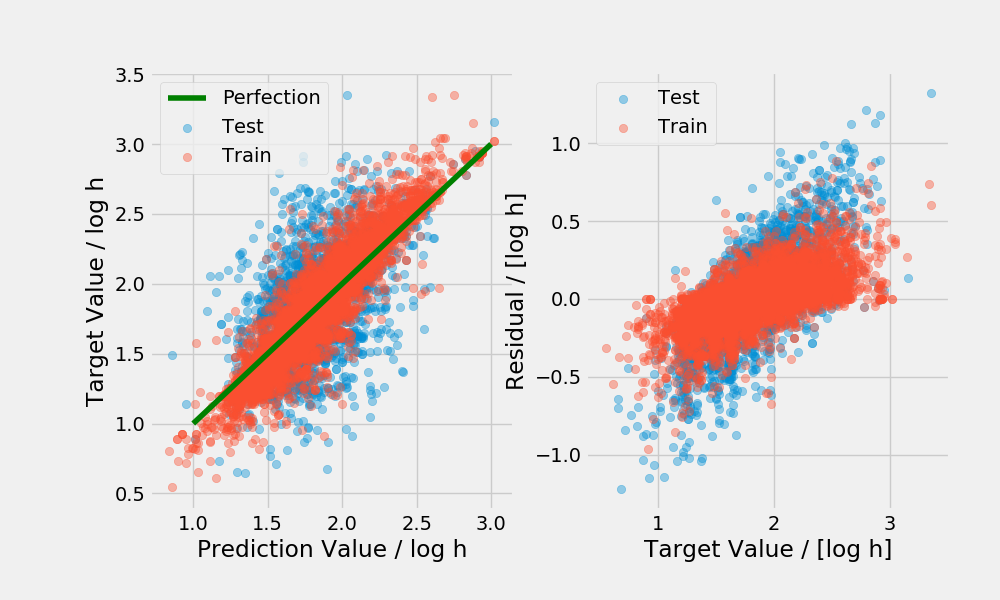

In [83]:
# "Goodness" plots for the reduced variance decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(bagreg2_pred, y_test2, label='Test', alpha=alpha)
axes[0].scatter(bagreg2_pred_train, y_train2, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test2, y_test-bagreg2_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train2, y_train-bagreg2_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


In [84]:
# Using the optimal decision tree 'treereg' determined above

bagreg = BaggingRegressor(DecisionTreeRegressor(max_features = 2000, random_state=1, max_depth = 12), random_state=1)#, bootstrap=True, oob_score=True)

bagreg.fit(X_train, y_train)
bagreg_pred = bagreg.predict(X_test)
bagreg_pred_train = bagreg.predict(X_train)

bagreg_train_MSE = metrics.mean_squared_error(y_pred=bagreg_pred_train,y_true=y_train)
bagreg_test_MSE = metrics.mean_squared_error(y_pred=bagreg_pred,y_true=y_test)
bagreg_MSE = np.mean(-cross_val_score(bagreg, X, y, cv=kf, scoring='neg_mean_squared_error'))


print('Bagged Treereg Train MSE: '+ str(bagreg_train_MSE))
print('Bagged Treereg Test MSE: '+ str(bagreg_test_MSE))
print('Bagged Treereg MSE: '+ str(bagreg_MSE))

Bagged Treereg Train MSE: 0.06219449586037899
Bagged Treereg Test MSE: 0.08926363505314884
Bagged Treereg MSE: 0.0865836992119717


<IPython.core.display.Javascript object>


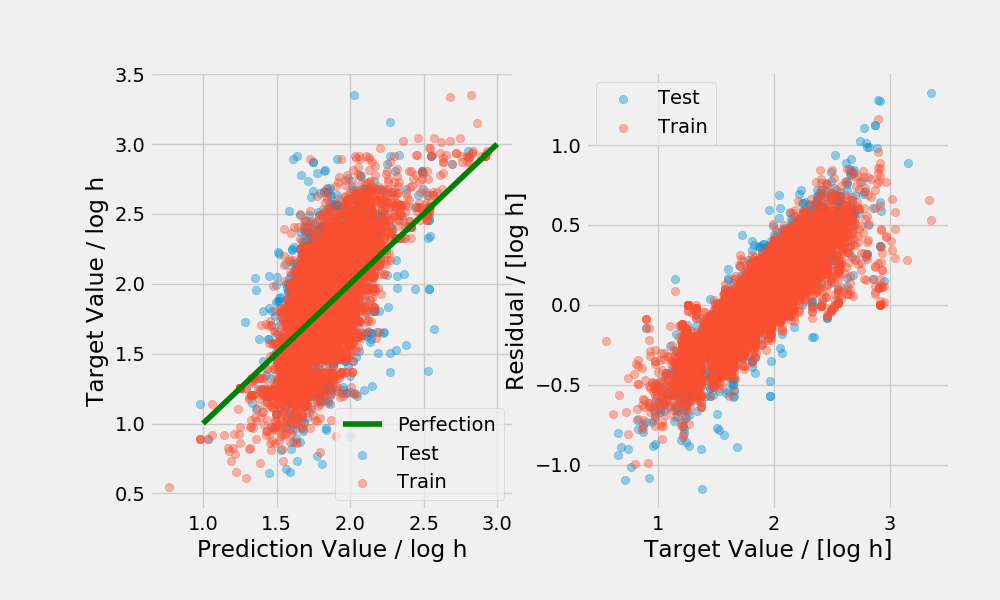

In [85]:
# "Goodness" plots for the reduced variance decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(bagreg_pred, y_test, label='Test', alpha=alpha)
axes[0].scatter(bagreg_pred_train, y_train, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test, y_test-bagreg_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train, y_train-bagreg_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


In [49]:
#For a range of max_samples:
train_MSE_scores = []
test_MSE_scores = []
CV_MSE_scores = []
max_samples_range = [1,10,100,1000,len(X_train)]

for max_sample in max_samples_range:
    bagreg = BaggingRegressor(DecisionTreeRegressor(random_state=1), random_state=1,max_samples=max_sample)
    bagreg.fit(X_train,y_train)
    
    bagreg_pred_train = bagreg.predict(X_train)
    bagreg_pred = bagreg.predict(X_test)
    
    bagreg_train_MSE = metrics.mean_squared_error(y_pred=bagreg_pred_train,y_true=y_train)
    bagreg_test_MSE = metrics.mean_squared_error(y_pred=bagreg_pred,y_true=y_test)
    bagreg_MSE = np.mean(-cross_val_score(bagreg, X, y, cv=kf, scoring='neg_mean_squared_error'))
    
    train_MSE_scores.append(np.mean(bagreg_train_MSE))
    test_MSE_scores.append(np.mean(bagreg_test_MSE))
    CV_MSE_scores.append(bagreg_MSE)
    
    print(max_sample)
    print(bagreg_train_MSE)
    print(bagreg_test_MSE)
    print(bagreg_MSE)    

bagreg_max_samples_df = pd.DataFrame({'max_samples':max_samples_range,'train':train_MSE_scores,'test':test_MSE_scores,'CV':CV_MSE_scores})
bagreg_max_samples_df

1
0.15950948848519103
0.16311197709362288
0.12654527916245847
10
0.11452594759488555
0.1190157335577104
0.12130878907422127
100
0.10737410966229563
0.11036292767984707
0.11143939756816942
1000
0.07858811180615129
0.10052223889259605
0.09892230981988324
8286
0.014528783317437082
0.08524885468424152
0.08266907973357654


,max_samples,train,test,CV
0,1,0.159509,0.163112,0.126545
1,10,0.114526,0.119016,0.121309
2,100,0.107374,0.110363,0.111439
3,1000,0.078588,0.100522,0.098922
4,8286,0.014529,0.085249,0.082669


<IPython.core.display.Javascript object>


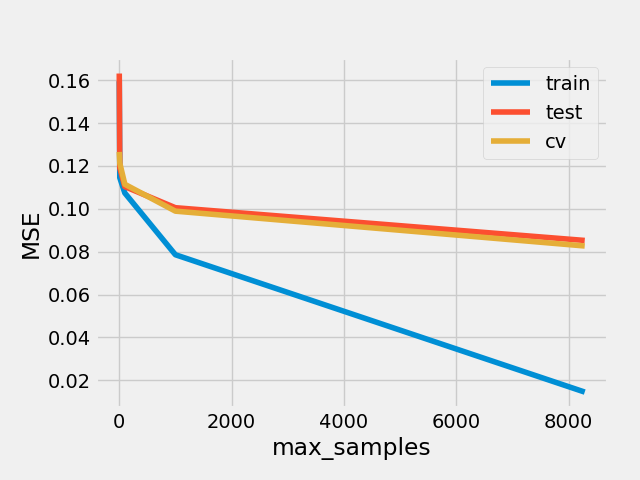

In [70]:
# plot the MSEs of models using the range of max_features
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

ax.plot(bagreg_max_samples_df['max_samples'], bagreg_max_samples_df['train'], label='train')
ax.plot(bagreg_max_samples_df['max_samples'], bagreg_max_samples_df['test'], label='test')
ax.plot(bagreg_max_samples_df['max_samples'], bagreg_max_samples_df['CV'], label='cv')

ax.set_xlabel('max_samples')
ax.set_ylabel('MSE')
ax.legend();

In [51]:
#For a range of n_estimators:
train_MSE_scores = []
test_MSE_scores = []
CV_MSE_scores = []
n_estimators_range = [1,10,100]#,1000,len(X_train)]

for n_estimator in n_estimators_range:
    bagreg = BaggingRegressor(DecisionTreeRegressor(random_state=1), random_state=1,n_estimators=n_estimator)
    bagreg.fit(X_train,y_train)
    
    bagreg_pred_train = bagreg.predict(X_train)
    bagreg_pred = bagreg.predict(X_test)
    
    bagreg_train_MSE = metrics.mean_squared_error(y_pred=bagreg_pred_train,y_true=y_train)
    bagreg_test_MSE = metrics.mean_squared_error(y_pred=bagreg_pred,y_true=y_test)
    bagreg_MSE = np.mean(-cross_val_score(bagreg, X, y, cv=kf, scoring='neg_mean_squared_error'))
    
    train_MSE_scores.append(np.mean(bagreg_train_MSE))
    test_MSE_scores.append(np.mean(bagreg_test_MSE))
    CV_MSE_scores.append(bagreg_MSE)
    
    print(n_estimator)
    print(bagreg_train_MSE)
    print(bagreg_test_MSE)
    print(bagreg_MSE)    

bagreg_n_estimators_df = pd.DataFrame({'n_estimators':n_estimators_range,'train':train_MSE_scores,'test':test_MSE_scores,'CV':CV_MSE_scores})
bagreg_n_estimators_df

1
0.050946132068393844
0.13699996040343373
0.13560176091259515
10
0.014528783317437082
0.08524885468424152
0.08164136903428187
100
0.010975358817357967
0.07999317441746703
0.07900323442962984


,n_estimators,train,test,CV
0,1,0.050946,0.137000,0.135602
1,10,0.014529,0.085249,0.081641
2,100,0.010975,0.079993,0.079003


<IPython.core.display.Javascript object>


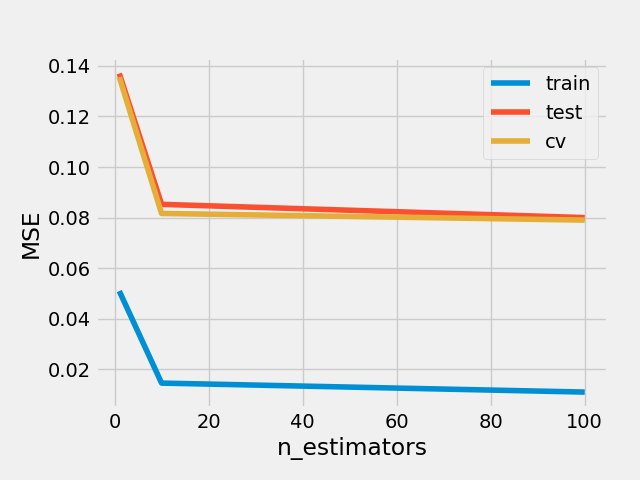

In [71]:
# plot the MSEs of models using the range of n_estimators
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

ax.plot(bagreg_n_estimators_df['n_estimators'], bagreg_n_estimators_df['train'], label='train')
ax.plot(bagreg_n_estimators_df['n_estimators'], bagreg_n_estimators_df['test'], label='test')
ax.plot(bagreg_n_estimators_df['n_estimators'], bagreg_n_estimators_df['CV'], label='cv')

ax.set_xlabel('n_estimators')
ax.set_ylabel('MSE')
ax.legend();

<IPython.core.display.Javascript object>


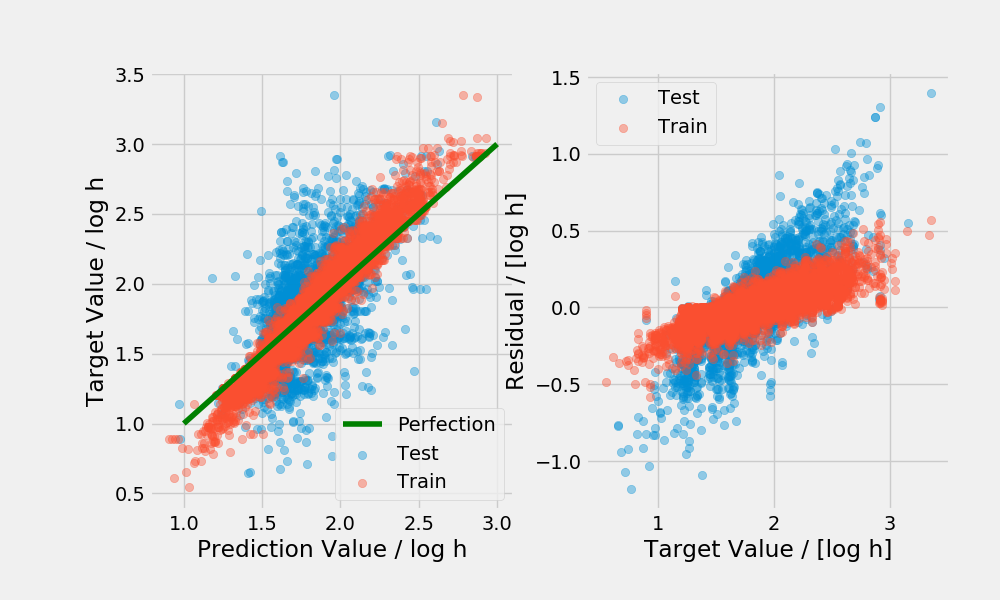

In [65]:
# "Goodness" plots for the optimized bagged decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(bagreg_pred, y_test, label='Test', alpha=alpha)
axes[0].scatter(bagreg_pred_train, y_train, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test, y_test-bagreg_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train, y_train-bagreg_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


### Random Forest Model
---
- The random forest model shows some improvement in terms of accuracy over the baddeg decision tree, but remains overfit.   
- Attemps to reduce the variance of the model with fewer features results in increased bias with no decrease in variance.
---
Random Forest model training MSE: **0.0145**   
Random Forest  model test MSE: **0.0869**  
Random Forest  model cross validaiton MSE = **0.0863**

In [86]:
# Make a random forest regressor with the default values
rfreg = RandomForestRegressor()#n_estimators=10, max_features=500, max_depth=7, oob_score=True, random_state=1)

rfreg.fit(X_train, y_train)
rfreg_pred = rfreg.predict(X_test)
rfreg_pred_train = rfreg.predict(X_train)

rfreg_train_MSE = metrics.mean_squared_error(y_pred=rfreg_pred_train,y_true=y_train)
rfreg_test_MSE = metrics.mean_squared_error(y_pred=rfreg_pred,y_true=y_test)
rfreg_MSE = np.mean(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error'))

print('Random Forest Train MSE: '+str(rfreg_train_MSE))
print('Random Forest Test MSE: '+str(rfreg_test_MSE))
print('Random Forest CV MSE: '+str(rfreg_MSE))

Random Forest Train MSE: 0.013843324260379975
Random Forest Test MSE: 0.08496757697178013
Random Forest CV MSE: 0.08297962417062243


<IPython.core.display.Javascript object>


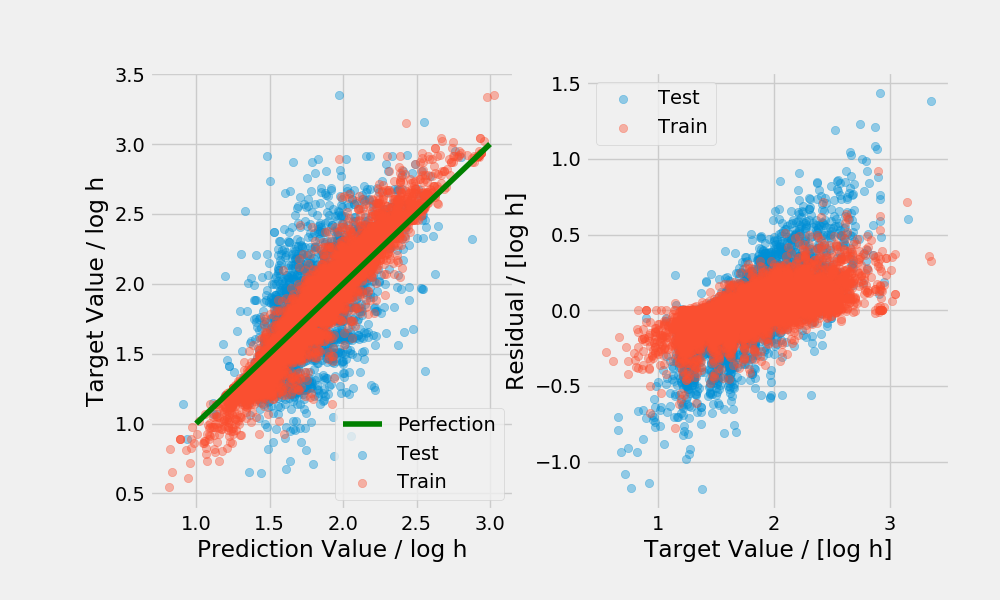

In [87]:
# "Goodness" plots for the reduced variance decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(rfreg_pred, y_test, label='Test', alpha=alpha)
axes[0].scatter(rfreg_pred_train, y_train, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test, y_test-rfreg_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train, y_train-rfreg_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


In [63]:
# Make a random forest regressor with the n_estimators and max_depth determined above. The appropriate max_features is determines below
rfreg = RandomForestRegressor(n_estimators=10, max_features=len(feature_cols), max_depth=12, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)
rfreg_pred = rfreg.predict(X_test)
rfreg_pred_train = rfreg.predict(X_train)

rfreg_train_MSE = metrics.mean_squared_error(y_pred=rfreg_pred_train,y_true=y_train)
rfreg_test_MSE = metrics.mean_squared_error(y_pred=rfreg_pred,y_true=y_test)
rfreg_MSE = np.mean(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error'))

print('Random Forest Train MSE: '+str(rfreg_train_MSE))
print('Random Forest Test MSE: '+str(rfreg_test_MSE))
print('Random Forest CV MSE: '+str(rfreg_MSE))

C:\Users\Lenovo Thinkpad W520\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lenovo Thinkpad W520\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lenovo Thinkpad W520\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lenovo Thinkpad W520\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute an

Random Forest Train MSE: 0.06136267174438396
Random Forest Test MSE: 0.08903958676623594
Random Forest CV MSE: 0.08599537085970495


<IPython.core.display.Javascript object>


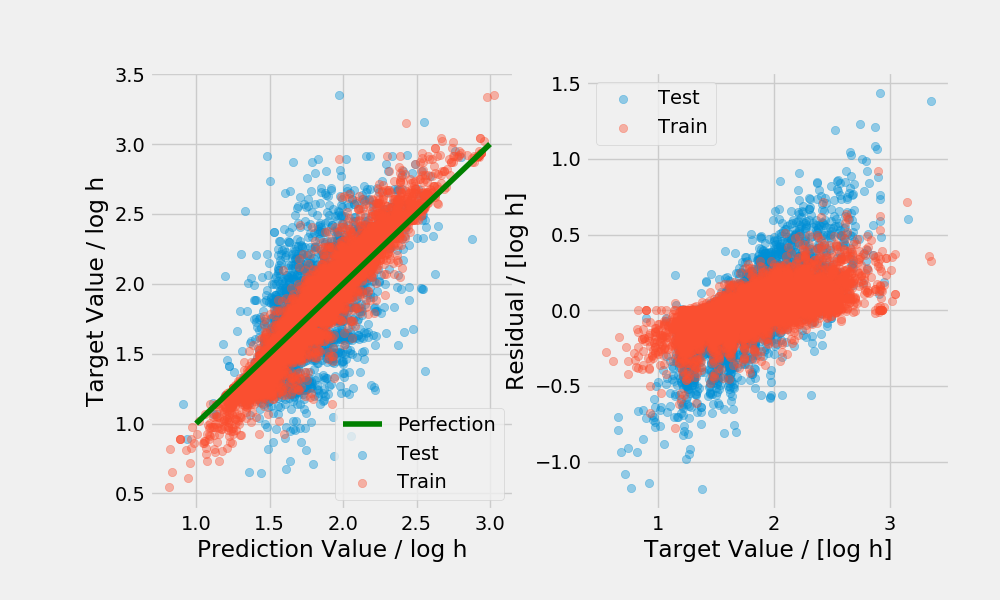

In [88]:
# "Goodness" plots for the reduced variance decision tree model:

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,6))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha=0.4

axes[0].scatter(rfreg_pred, y_test, label='Test', alpha=alpha)
axes[0].scatter(rfreg_pred_train, y_train, label='Train', alpha=alpha)
axes[0].plot([1,3],[1,3], label = 'Perfection',color='g')
axes[0].set_xlabel('Prediction Value / log h')
axes[0].set_ylabel('Target Value / log h')
axes[0].legend()

axes[1].scatter(y_test, y_test-rfreg_pred, label='Test', alpha=alpha)
axes[1].scatter(y_train, y_train-rfreg_pred_train, label='Train', alpha=alpha)
axes[1].set_xlabel('Target Value / [log h]')
axes[1].set_ylabel('Residual / [log h]')
axes[1].legend();


In [94]:
#For a range of n_estimators:
train_MSE_scores = []
test_MSE_scores = []
CV_MSE_scores = []
n_estimators_range = [1,10,20]#,1000,len(X_train)]

for n_estimator in n_estimators_range:
    rfreg = RandomForestRegressor(random_state=1, n_estimators=n_estimator)
    rfreg.fit(X_train,y_train)
    
    rfreg_pred_train = rfreg.predict(X_train)
    rfreg_pred = rfreg.predict(X_test)
    
    rfreg_train_MSE = metrics.mean_squared_error(y_pred=rfreg_pred_train,y_true=y_train)
    rfreg_test_MSE = metrics.mean_squared_error(y_pred=rfreg_pred,y_true=y_test)
    rfreg_MSE = np.mean(-cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error'))
    
    train_MSE_scores.append(np.mean(rfreg_train_MSE))
    test_MSE_scores.append(np.mean(rfreg_test_MSE))
    CV_MSE_scores.append(rfreg_MSE)
    
    print(n_estimator)
    print(rfreg_train_MSE)
    print(rfreg_test_MSE)
    print(rfreg_MSE)    

rfreg_n_estimators_df = pd.DataFrame({'n_estimators':n_estimators_range,'train':train_MSE_scores,'test':test_MSE_scores,'CV':CV_MSE_scores})
rfreg_n_estimators_df

1
0.050422339109865114
0.1381691402760003
0.13676851876637797
10
0.014452005262846871
0.08549791019501302
0.08304584019812435


,n_estimators,train,test,CV
0,1,0.050422,0.138169,0.136769
1,10,0.014452,0.085498,0.083046


<IPython.core.display.Javascript object>


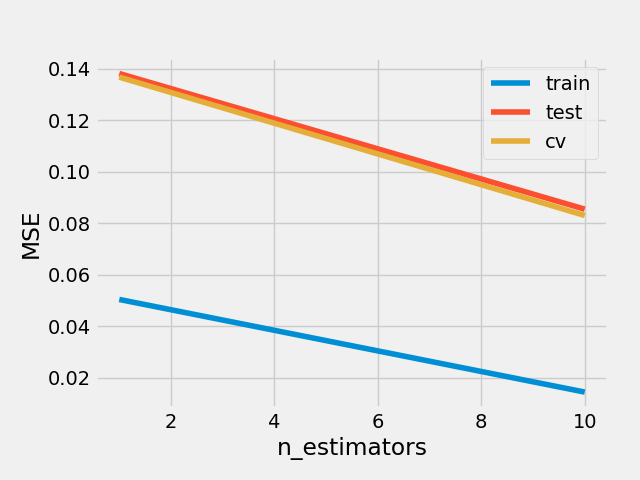

In [95]:
# plot the MSEs of models using the range of n_estimators
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

ax.plot(rfreg_n_estimators_df['n_estimators'], rfreg_n_estimators_df['train'], label='train')
ax.plot(rfreg_n_estimators_df['n_estimators'], rfreg_n_estimators_df['test'], label='test')
ax.plot(rfreg_n_estimators_df['n_estimators'], rfreg_n_estimators_df['CV'], label='cv')

ax.set_xlabel('n_estimators')
ax.set_ylabel('MSE')
ax.legend();

In [189]:
# What are the most important feaures?
imps = pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance',ascending=False)
feature_cols_imp20 = list(imps.reset_index()['feature'][0:20])
feature_cols_imp200 = list(imps.reset_index()['feature'][0:200])

In [190]:
feature_cols_imp20

['hours_since_last_move',
 'Hours at Station',
 'Tare Weight',
 'Switch To Address Type_RUM',
 'Weight',
 'Traffic Type_R',
 'Length_in_ft',
 'Track ID_01        ',
 'Car Hire Rate',
 'is_summer',
 'Track ID_SWITCH    ',
 'is_fall',
 'Track ID_02        ',
 'Track ID_07        ',
 'Traffic Type_L',
 'Last Move Type_LOC ',
 'Track ID_08        ',
 'Shipper Customer ID_TIGWAR   ',
 'Track ID_04        ',
 'Track ID_05        ']

# Visualize Model 'Goodness'
---
All models seem to be overfit. Attempts to reduce bias an decrease variance result in an increase in bias and poor fits on both the training and test data. The most accurate model could only predict the car dwell time to __h of its true value on average which is only __h better than the trival model that predicts the mean dwell time for all arriving cars.

### On the test
---

<IPython.core.display.Javascript object>


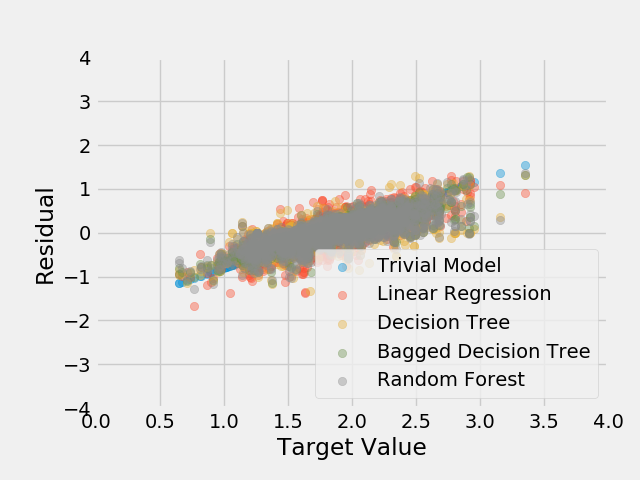

In [97]:
# Plot residuals for each model: 
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

null_residuals = y_test - y_null_pred
lr_residuals = y_test - lr_pred
treereg_residuals = y_test - treereg_pred
bagreg_residuals = y_test - bagreg_pred
rfreg_residuals = y_test - rfreg_pred

maxi=4
alpha = 0.4

ax.scatter(y_test, null_residuals, label='Trivial Model',alpha = alpha)
ax.scatter(y_test, lr_residuals, label='Linear Regression',alpha = alpha)
ax.scatter(y_test, treereg_residuals, label='Decision Tree',alpha = alpha)
ax.scatter(y_test, bagreg_residuals, label='Bagged Decision Tree',alpha = alpha)
ax.scatter(y_test, rfreg_residuals, label='Random Forest', alpha = alpha)


ax.set_xlabel('Target Value')
ax.set_ylabel('Residual')
ax.set_xlim(0,maxi)
ax.set_ylim(-maxi,maxi)

leg=ax.legend()

<IPython.core.display.Javascript object>


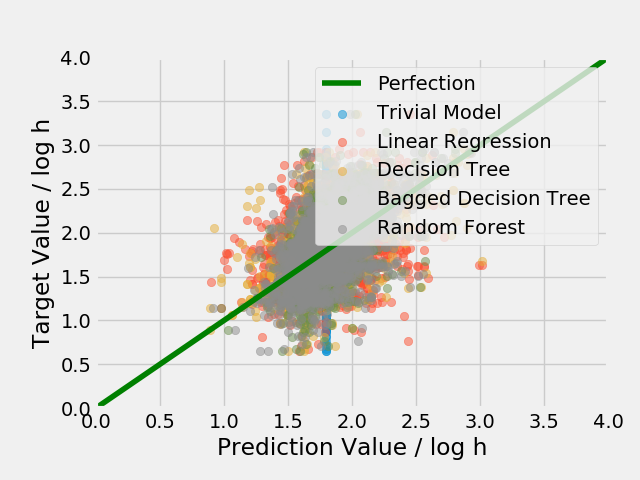

In [98]:
# Plot true values vs predictions for each model:
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha = 0.5
maxi = 4

ax.scatter(y_null_pred, y_test, label='Trivial Model',alpha = alpha)
ax.scatter(lr_pred, y_test, label='Linear Regression',alpha = alpha)
ax.scatter(treereg_pred, y_test, label='Decision Tree',alpha = alpha)
ax.scatter(bagreg_pred, y_test, label='Bagged Decision Tree',alpha = alpha)
ax.scatter(rfreg_pred, y_test, label='Random Forest',alpha = alpha)
ax.plot([0,maxi],[0,maxi], label = 'Perfection',color='g')

ax.set_xlim(0,maxi)
ax.set_ylim(0,maxi)
ax.set_xlabel('Prediction Value / log h')
ax.set_ylabel('Target Value / log h')

leg = ax.legend()

### On the train
---

<IPython.core.display.Javascript object>


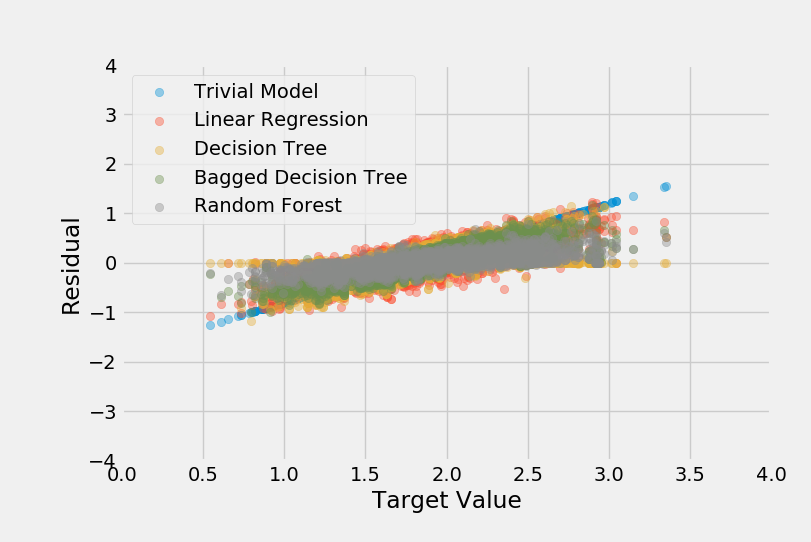

In [99]:
# Plot residuals for each model: 
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

null_residuals = y_train - (np.zeros(len(y_train))+y_null_pred.mean())
lr_residuals = y_train - lr_pred_train
treereg_residuals = y_train - treereg_pred_train
bagreg_residuals = y_train - bagreg_pred_train
rfreg_residuals = y_train - rfreg_pred_train

maxi=4
alpha = 0.4

ax.scatter(y_train, null_residuals, label='Trivial Model',alpha = alpha)
ax.scatter(y_train, lr_residuals, label='Linear Regression',alpha = alpha)
ax.scatter(y_train, treereg_residuals, label='Decision Tree',alpha = alpha)
ax.scatter(y_train, bagreg_residuals, label='Bagged Decision Tree',alpha = alpha)
ax.scatter(y_train, rfreg_residuals, label='Random Forest', alpha = alpha)


ax.set_xlabel('Target Value')
ax.set_ylabel('Residual')
ax.set_xlim(0,maxi)
ax.set_ylim(-maxi,maxi)

leg=ax.legend()

<IPython.core.display.Javascript object>


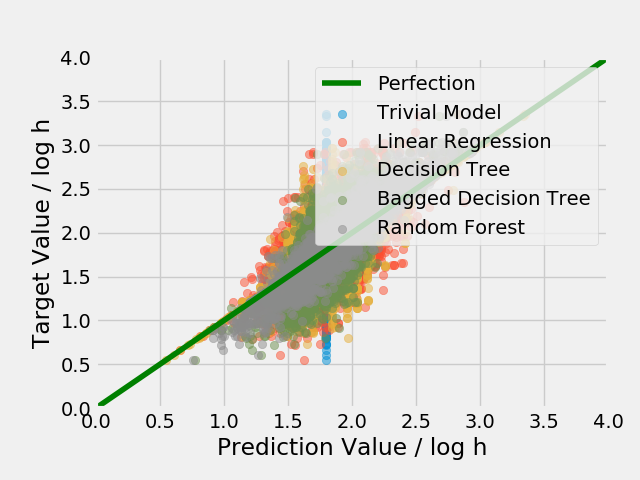

In [100]:
# Plot true values vs predictions for each model:
fig, ax = plt.subplots()

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha = 0.5
maxi = 4

ax.scatter(np.zeros(len(y_train))+y_null_pred.mean(), y_train, label='Trivial Model',alpha = alpha)
ax.scatter(lr_pred_train, y_train, label='Linear Regression',alpha = alpha)
ax.scatter(treereg_pred_train, y_train, label='Decision Tree',alpha = alpha)
ax.scatter(bagreg_pred_train, y_train, label='Bagged Decision Tree',alpha = alpha)
ax.scatter(rfreg_pred_train, y_train, label='Random Forest',alpha = alpha)
ax.plot([0,maxi],[0,maxi], label = 'Perfection',color='g')

ax.set_xlim(0,maxi)
ax.set_ylim(0,maxi)
ax.set_xlabel('Prediction Value / log h')
ax.set_ylabel('Target Value / log h')

leg = ax.legend()

### Accuracy
---

<IPython.core.display.Javascript object>


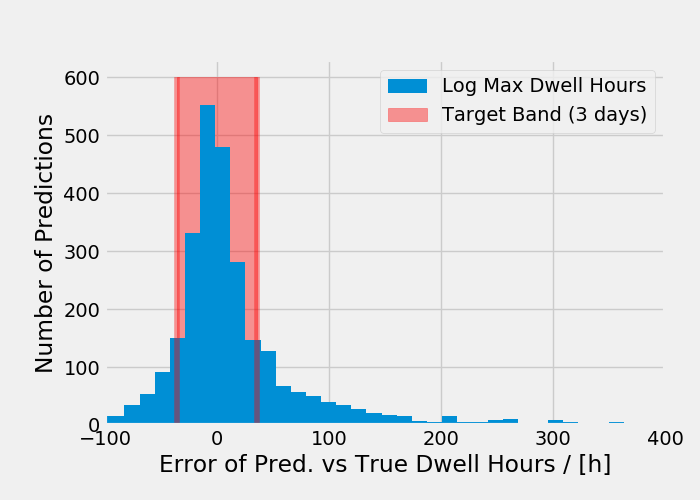

In [172]:
resid_hours = (10**(y_test)-10**(rfreg_pred))

fig,ax = plt.subplots(figsize=(7,5))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha = 0.4
ax.hist(resid_hours,bins=200)
ax.vlines(x=36, ymax=600,ymin=0, color = 'r', alpha =alpha)
ax.vlines(x=-36, ymax=600,ymin=0, color = 'r', alpha = alpha)
ax.fill_between(x = [-36,36],y1=[0,0],y2=[600,600], color = 'r', alpha = alpha, label = 'Target Band (3 days)')

ax.set_xlabel('Error of Pred. vs True Dwell Hours / [h]')
ax.set_ylabel('Number of Predictions')
ax.legend()
ax.set_xlim(-100,400);

In [173]:
resid_hours.describe()#percentiles=[.74])

count    2.763000e+03
mean     2.017148e+01
std      9.628881e+01
min     -5.419341e+02
25%     -1.613426e+01
50%      1.421085e-14
75%      2.819005e+01
max      2.159642e+03
Name: Log Max Dwell Hours, dtype: float64

In [175]:
len(resid_hours[(resid_hours>-32) & (resid_hours<32)])/len(resid_hours)*100

63.952225841476654

<IPython.core.display.Javascript object>


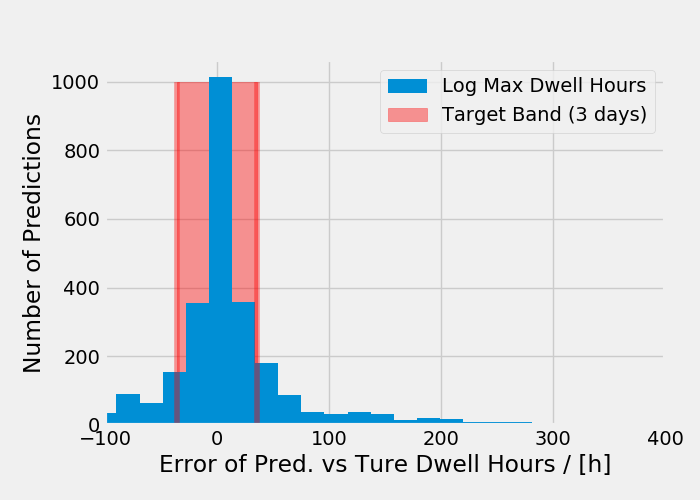

In [176]:
resid_hours = (10**(y_test)-10**(treereg_pred))

fig,ax = plt.subplots(figsize=(7,5))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha = 0.4
height = 1000
ax.hist(resid_hours,bins=200)
ax.vlines(x=36, ymax=height,ymin=0, color = 'r', alpha =alpha)
ax.vlines(x=-36, ymax=height,ymin=0, color = 'r', alpha = alpha)
ax.fill_between(x = [-36,36],y1=[0,0],y2=[height,height], color = 'r', alpha = alpha, label = 'Target Band (3 days)')

ax.set_xlabel('Error of Pred. vs Ture Dwell Hours / [h]')
ax.set_ylabel('Number of Predictions')
ax.legend()
ax.set_xlim(-100,400);

In [177]:
resid_hours.describe()

count    2763.000000
mean        5.308104
std       116.051105
min     -1967.950000
25%       -23.008333
50%         0.000000
75%        23.966667
max      2159.833333
Name: Log Max Dwell Hours, dtype: float64

In [178]:
len(resid_hours[(resid_hours>-32) & (resid_hours<32)])/len(resid_hours)*100

62.902642055736514

<IPython.core.display.Javascript object>


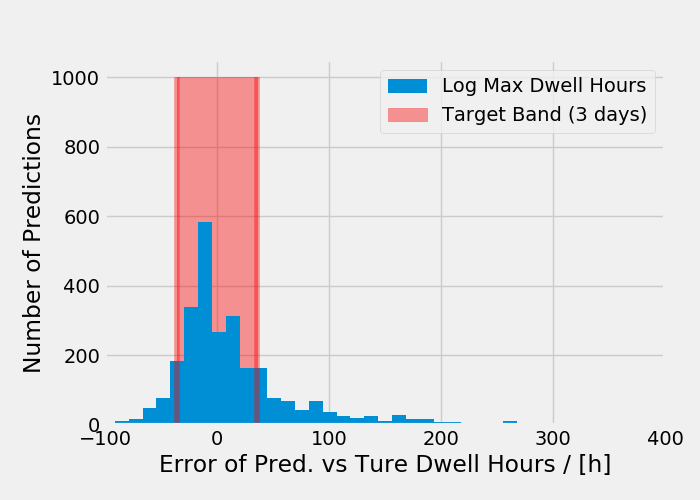

In [182]:
resid_hours = (10**(y_test)-10**(bagreg_pred))

fig,ax = plt.subplots(figsize=(7,5))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha = 0.4
height = 1000
ax.hist(resid_hours,bins=200)
ax.vlines(x=36, ymax=height,ymin=0, color = 'r', alpha =alpha)
ax.vlines(x=-36, ymax=height,ymin=0, color = 'r', alpha = alpha)
ax.fill_between(x = [-36,36],y1=[0,0],y2=[height,height], color = 'r', alpha = alpha, label = 'Target Band (3 days)')

ax.set_xlabel('Error of Pred. vs Ture Dwell Hours / [h]')
ax.set_ylabel('Number of Predictions')
ax.legend()
ax.set_xlim(-100,400);

In [180]:
resid_hours.describe()

count    2763.000000
mean       23.801720
std        97.503569
min      -326.105080
25%       -17.210381
50%        -0.145631
75%        34.016450
max      2147.358937
Name: Log Max Dwell Hours, dtype: float64

In [183]:
len(resid_hours[(resid_hours>-32) & (resid_hours<32)])/len(resid_hours)*100

62.25117625769092

<IPython.core.display.Javascript object>


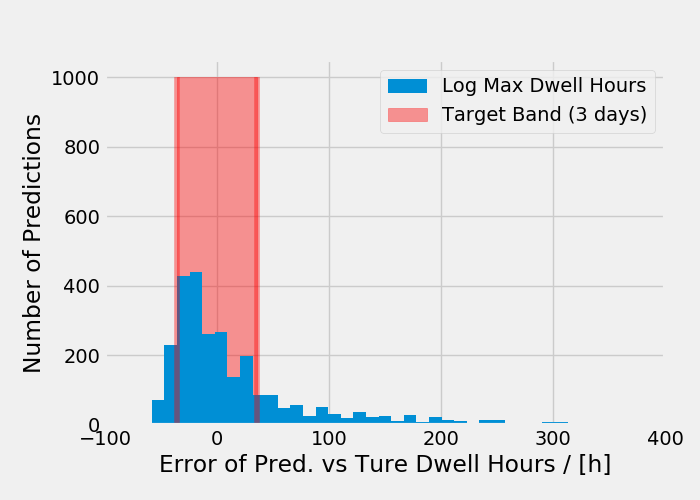

In [184]:
resid_hours = (10**(y_test)-10**(y_null_pred))

fig,ax = plt.subplots(figsize=(7,5))

plt.gcf().subplots_adjust(left=0.15) 
plt.gcf().subplots_adjust(bottom=0.15)

alpha = 0.4
height = 1000
ax.hist(resid_hours,bins=200)
ax.vlines(x=36, ymax=height,ymin=0, color = 'r', alpha =alpha)
ax.vlines(x=-36, ymax=height,ymin=0, color = 'r', alpha = alpha)
ax.fill_between(x = [-36,36],y1=[0,0],y2=[height,height], color = 'r', alpha = alpha, label = 'Target Band (3 days)')

ax.set_xlabel('Error of Pred. vs Ture Dwell Hours / [h]')
ax.set_ylabel('Number of Predictions')
ax.legend()
ax.set_xlim(-100,400);

In [185]:
resid_hours.describe(percentiles=[0.80])

count    2763.000000
mean       29.919793
std       112.663023
min       -58.134900
50%        -4.368234
80%        54.631766
max      2191.115100
Name: Log Max Dwell Hours, dtype: float64

In [186]:
len(resid_hours[(resid_hours>-32) & (resid_hours<32)])/len(resid_hours)*100

57.6909156713717

In [191]:
resid_hours = (10**(y_test)-10**(lr_pred))

# fig,ax = plt.subplots(figsize=(7,5))

# plt.gcf().subplots_adjust(left=0.15) 
# plt.gcf().subplots_adjust(bottom=0.15)

# alpha = 0.4
# height = 1000
# ax.hist(resid_hours,bins=200)
# ax.vlines(x=36, ymax=height,ymin=0, color = 'r', alpha =alpha)
# ax.vlines(x=-36, ymax=height,ymin=0, color = 'r', alpha = alpha)
# ax.fill_between(x = [-36,36],y1=[0,0],y2=[height,height], color = 'r', alpha = alpha, label = 'Target Band (3 days)')

# ax.set_xlabel('Error of Pred. vs Ture Dwell Hours / [h]')
# ax.set_ylabel('Number of Predictions')
# ax.legend()
# ax.set_xlim(-100,400);

C:\Users\Lenovo Thinkpad W520\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in power
  """Entry point for launching an IPython kernel.


In [192]:
resid_hours.replace(-np.inf,np.nan).dropna().describe(percentiles=[0.71])

count    2660.000000
mean       20.754983
std       115.209820
min      -996.134832
50%         1.629639
71%        31.167955
max      1969.974201
Name: Log Max Dwell Hours, dtype: float64

In [193]:
len(resid_hours[(resid_hours>-32) & (resid_hours<32)])/len(resid_hours)*100

48.42562432138979